In [0]:
!pip install torch_nightly -f https://download.pytorch.org/whl/nightly/cu90/torch_nightly.html
!pip install fastai
!wget www.pendar2.com/cifar10.zip
!wget www.pendar2.com/mnist.zip
!unzip cifar10.zip > zip-log
!unzip mnist.zip

In [0]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [0]:
import tensorflow as tf
import tensorflow.keras as keras

In [0]:
#opts = tf.GPUOptions(per_process_gpu_memory_fraction=0.5)
#conf = tf.ConfigProto(gpu_options=opts)
#tf.enable_eager_execution(config=conf)
tf.enable_eager_execution()
tfe = tf.contrib.eager

In [0]:
from fastai import *

In [0]:
from fastai.torch_core import *
from fastai.data import *
from fastai.callback import *

# Learner

In [0]:
flatten_model_tf=lambda m: sum(map(flatten_model_tf,m.layers),[]) if hasattr(m, "layers") else [m]

In [0]:
bn_types += (tf.keras.layers.BatchNormalization,) #TODO more types?

In [0]:
tf.Tensor.detach = lambda x: x.numpy()

In [0]:
default_lr = 3e-3
default_wd = 1e-2

In [0]:
def loss_batch(model, xb, yb, loss_fn=None, opt=None, cb_handler=None, metrics=None):
    "Calculate loss and metrics for a batch, call out to callbacks as necessary."
    if cb_handler is None: cb_handler = CallbackHandler([])
    if not is_listy(xb): xb = [xb]
    if not is_listy(yb): yb = [yb]
    
    xb = [tf.constant(v.cpu().numpy()) for v in xb]
    yb = [tf.constant(v.cpu().numpy()) for v in yb]
    
    
    
    #TODO: dont remember grads if no opt -- currently inefficient for validation
    with tf.GradientTape() as tape:
        out = model(*xb)
        out = cb_handler.on_loss_begin(out)
        if not loss_fn: return out,yb[0]
        loss = loss_fn(*yb, out) #reversed params compared to pytorch
        mets = [f(*yb, out).numpy() for f in metrics] if metrics is not None else [] #note metrics params order
        loss = cb_handler.on_backward_begin(loss)
        
    
    if opt is not None:
        grads = tape.gradient(loss, model.trainable_variables)
        cb_handler.on_backward_end()
        opt.apply_gradients(zip(grads, model.trainable_variables))
        cb_handler.on_step_end()
    
    return (loss.numpy(),) + tuple(mets) + (int(yb[0].shape[0]),)
    

def validate(model, dl, loss_fn=None, metrics=None, cb_handler=None, pbar=None):
    "Calculate loss and metrics for the validation set."
    return zip(*[loss_batch(model, xb, yb, loss_fn, cb_handler=cb_handler, metrics=metrics)
                       for xb,yb in progress_bar(dl, parent=pbar, leave=(pbar is not None))])


def train_epoch(model, dl, opt, loss_func):
    "Simple training of `model` for 1 epoch of `dl` using optim `opt` and loss function `loss_func`."
    raise NotImplementedError

def fit(epochs, model, loss_fn, opt, data, callbacks, metrics):
    cb_handler = CallbackHandler(callbacks)
    pbar = master_bar(range(epochs))
    cb_handler.on_train_begin(epochs, pbar=pbar, metrics=metrics)

    exception=False
    try:
        for epoch in pbar:
            cb_handler.on_epoch_begin()

            for xb,yb in progress_bar(data.train_dl, parent=pbar):
                xb, yb = cb_handler.on_batch_begin(xb, yb)
                loss,_ = loss_batch(model, xb, yb, loss_fn, opt, cb_handler)
                if cb_handler.on_batch_end(loss): break

            if hasattr(data,'valid_dl') and data.valid_dl is not None:
                *val_metrics,nums = validate(model, data.valid_dl, loss_fn=loss_fn,
                                             cb_handler=cb_handler, metrics=metrics,pbar=pbar)
                nums = np.array(nums, dtype=np.float32)
                val_metrics = [np.sum(np.multiply(val,nums)) / np.sum(nums) for val in val_metrics]

            else: val_metrics=None
            if cb_handler.on_epoch_end(val_metrics): break
    except Exception as e:
        exception = e
        raise e
    finally: cb_handler.on_train_end(exception)

In [0]:
#TODO: discrim lr
@dataclass
class TFLearner():
    "Train `model` using `data` to minimize `loss_fn` with optimizer `opt_fn`."
    data:DataBunch
    model:Any
    opt_fn:Callable
    loss_fn:Callable
    metrics:Collection[Callable]=None
    true_wd:bool=True #not implemented
    bn_wd:bool=True #not implemented
    wd:Floats=default_wd #not implemented
    train_bn:bool=True #not implemented
    path:str = None
    model_dir:str = 'models'
    callback_fns:Collection[Callable]=None
    callbacks:Collection[Callback]=field(default_factory=list)
    layer_groups:Collection[Any]=None
    def __post_init__(self)->None:
        "Setup path,metrics, callbacks and ensure model directory exists."
        self.path = Path(ifnone(self.path, self.data.path))
        (self.path/self.model_dir).mkdir(parents=True, exist_ok=True)
        self.metrics=listify(self.metrics)
        if not self.layer_groups: self.layer_groups = flatten_model_tf(self.model)
        self.callbacks = listify(self.callbacks)
        self.callback_fns = [Recorder] + listify(self.callback_fns)
        
        #build the model by running 1 batch
        xb, yb = next(iter(self.data.train_dl))
        loss_batch(self.model, xb, yb)

    def init(self, init): raise NotImplementedError

    def lr_range(self, lr:Union[float,slice])->np.ndarray:
        "Build differential learning rates."
        if not isinstance(lr,slice): return lr
        if lr.start: res = even_mults(lr.start, lr.stop, len(self.layer_groups))
        else: res = [lr.stop/3]*(len(self.layer_groups)-1) + [lr.stop]
        return np.array(res)

    def fit(self, epochs:int, lr:Union[Floats,slice]=default_lr, wd:Floats=None, callbacks:Collection[Callback]=None)->None:
        "Fit the model on this learner with `lr` learning rate, `wd` weight decay for `epochs` with `callbacks`."
        lr = self.lr_range(lr)
        self.create_opt(lr)
        callbacks = [cb(self) for cb in self.callback_fns] + listify(callbacks)
        fit(epochs, self.model, self.loss_fn, opt=self.opt, data=self.data, metrics=self.metrics,
            callbacks=self.callbacks+callbacks)

    def create_opt(self, lr:Floats)->None:
        "Create optimizer with `lr` learning rate and `wd` weight decay."
        self.opt = TFOptimWrapper.create(self.opt_fn, lr)

    def split(self, split_on:SplitFuncOrIdxList)->None:
        "Split the model at `split_on`."
        raise NotImplementedError

    def freeze_to(self, n:int)->None:
        "Freeze layers up to layer `n`."
        for g in self.layer_groups[:n]:
            if not self.train_bn or not isinstance(g, bn_types): g.trainable = False
                
        for g in self.layer_groups[n:]: g.trainable = True

    def freeze(self)->None:
        "Freeze up to last layer."
        assert(len(self.layer_groups)>1)
        self.freeze_to(-1)

    def unfreeze(self):
        "Unfreeze entire model."
        self.freeze_to(0)

    def __del__(self): del(self.model, self.data)

    def save(self, name:PathOrStr):
        "Save model with `name` to `self.model_dir`."
        root = tf.train.Checkpoint(model=self.model)
        root.save(file_prefix=self.path/self.model_dir/f'{name}')


    def load(self, name:PathOrStr):
        "Load model `name` from `self.model_dir`."
        root = tf.train.Checkpoint(model=self.model)
        root.restore(str(self.path/self.model_dir/f'{name}-1'))

In [0]:
TFLearner.fit_one_cycle = fit_one_cycle
TFLearner.lr_find = lr_find

# Optim Wrapper

In [0]:
#TODO: implement other hyperparams, discrim lr, true_wd, bn_wd/wd
class TFOptimWrapper():
    def __init__(self, opt_fn):
        self._lr = tfe.Variable(0.0)
        self._mom = tfe.Variable(0.0)
        
        opt_params = inspect.signature(opt_fn).parameters
        params = {}
        if opt_params.get("momentum"):
            self.mom = opt_params.get("momentum").default
            params["momentum"] = self._mom
        if opt_params.get("beta1"):
            self.mom = opt_params.get("beta1").default
            params["beta1"] = self._mom
        
        
        self.opt = opt_fn(learning_rate=self._lr, **params)
        
        
    @classmethod
    def create(cls, opt_fn, lr, **kwargs):
        opt = cls(opt_fn, **kwargs)

        opt.lr = lr
        return opt
    
        
    def apply_gradients(self, grads_and_vars):
        self.opt.apply_gradients(grads_and_vars)
        
    
    @property
    def lr(self)->float:
        "Get learning rate."
        return self._lr.numpy()

    @lr.setter
    def lr(self, val:float)->None:
        "Set learning rate."
        if not isinstance(val, float): val = val[-1]
        self._lr.assign(val)

    @property
    def mom(self)->float:
        "Get momentum."
        return self._mom.numpy()

    @mom.setter
    def mom(self, val:float)->None:
        "Set momentum."
        if not isinstance(val, float): val = val[-1]
        self._mom.assign(val)


# Testing

In [0]:
DATA_PATH = Path('./')

In [0]:
opt_fn = tf.train.AdamOptimizer

In [0]:
loss_fn = tf.losses.sparse_softmax_cross_entropy

In [0]:
def categorical_accuracy_fastai(y_true, y_pred):
    return tf.keras.backend.mean(tf.keras.backend.equal(y_true, tf.keras.backend.argmax(y_pred, axis=-1)))

In [0]:
metrics = [categorical_accuracy_fastai]

## MNIST with tf.keras.Model

In [0]:
import gzip, pickle
MNIST_PATH = DATA_PATH/'mnist'

with gzip.open(MNIST_PATH/'mnist.pkl.gz', 'rb') as f:
    ((x_train, y_train), (x_valid, y_valid), _) = pickle.load(f, encoding='latin-1')

x_train,y_train,x_valid,y_valid = map(torch.tensor, (x_train,y_train,x_valid,y_valid))
train_ds = TensorDataset(x_train, y_train)
valid_ds = TensorDataset(x_valid, y_valid)
train_dl = DataLoader(train_ds, 64)
valid_dl = DataLoader(valid_ds, 64)

In [0]:
data = DataBunch(train_dl, valid_dl, path=MNIST_PATH)

In [0]:
class Mnist_CNN(tf.keras.Model):
    def __init__(self):
        super().__init__()
        self.conv1 = tf.keras.layers.Conv2D(16, kernel_size=3, strides=(2,2), padding='same')
        self.conv2 = tf.keras.layers.Conv2D(16, kernel_size=3, strides=(2,2), padding='same')
        self.conv3 = tf.keras.layers.Conv2D(10, kernel_size=3, strides=(2,2), padding='same')
    def call(self, xb):
        xb = tf.reshape(xb, (-1, 28,28, 1))
        xb = tf.nn.relu(self.conv1(xb))
        xb = tf.nn.relu(self.conv2(xb))
        xb = tf.nn.relu(self.conv3(xb))
        xb = tf.nn.pool(xb, (4,4), 'AVG', 'VALID')
        xb = tf.reshape(xb, (-1, 10))
        return xb

In [0]:
model = Mnist_CNN()

In [0]:
learn = TFLearner(data, model, opt_fn, loss_fn, metrics=metrics)

In [24]:
lr_find(learn)

epoch  train loss  valid loss  categorical_accuracy_fastai
0      2.186483  


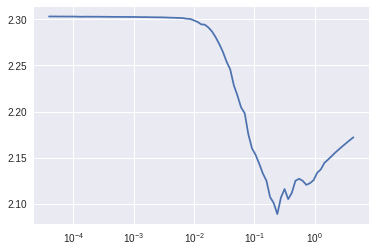

In [25]:
learn.recorder.plot()

In [26]:
learn.fit(1)

epoch  train loss  valid loss  categorical_accuracy_fastai
0      0.500206    0.534446    0.842200                   


In [27]:
fit_one_cycle(learn, 3)

epoch  train loss  valid loss  categorical_accuracy_fastai
0      0.378091    0.408442    0.878300                   
1      0.251839    0.267252    0.923800                   
2      0.231474    0.244411    0.929300                   


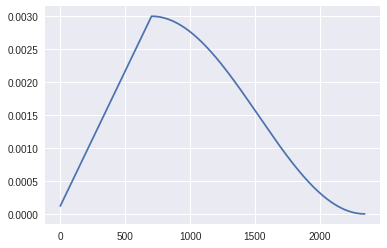

In [28]:
learn.recorder.plot_lr()

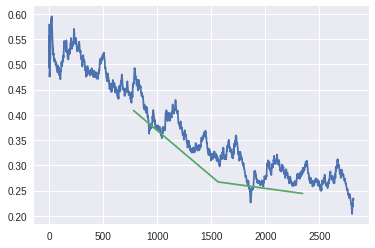

In [29]:
learn.recorder.plot_losses()

In [0]:
learn.save("test-mnist")

In [0]:
learn.load("test-mnist")

## CIFAR with Keras functional API

In [0]:
from fastai.vision import *

In [0]:
CIFAR_PATH = DATA_PATH/"cifar10"

In [0]:
ds_tfms = ([pad(padding=4), crop(size=32, row_pct=(0,1), col_pct=(0,1)), flip_lr(p=0.5)], [])
data = image_data_from_folder(CIFAR_PATH, valid='test', tfms=cifar_norm, bs=512)

In [0]:
xb, yb = next(iter(data.train_dl))

In [36]:
xb.shape, yb.shape

(torch.Size([512, 3, 32, 32]), torch.Size([512]))

In [0]:
#from https://github.com/raghakot/keras-resnet
import six
from tensorflow.keras.models import Model
from tensorflow.keras.layers import *

from tensorflow.keras.regularizers import l2
from tensorflow.keras import backend as K


def _bn_relu(input):
    """Helper to build a BN -> relu block
    """
    norm = BatchNormalization(axis=CHANNEL_AXIS)(input)
    return Activation("relu")(norm)


def _conv_bn_relu(**conv_params):
    """Helper to build a conv -> BN -> relu block
    """
    filters = conv_params["filters"]
    kernel_size = conv_params["kernel_size"]
    strides = conv_params.setdefault("strides", (1, 1))
    kernel_initializer = conv_params.setdefault("kernel_initializer", "he_normal")
    padding = conv_params.setdefault("padding", "same")
    kernel_regularizer = conv_params.setdefault("kernel_regularizer", l2(1.e-4))

    def f(input):
        conv = Conv2D(filters=filters, kernel_size=kernel_size,
                      strides=strides, padding=padding,
                      kernel_initializer=kernel_initializer,
                      kernel_regularizer=kernel_regularizer)(input)
        return _bn_relu(conv)

    return f


def _bn_relu_conv(**conv_params):
    """Helper to build a BN -> relu -> conv block.
    This is an improved scheme proposed in http://arxiv.org/pdf/1603.05027v2.pdf
    """
    filters = conv_params["filters"]
    kernel_size = conv_params["kernel_size"]
    strides = conv_params.setdefault("strides", (1, 1))
    kernel_initializer = conv_params.setdefault("kernel_initializer", "he_normal")
    padding = conv_params.setdefault("padding", "same")
    kernel_regularizer = conv_params.setdefault("kernel_regularizer", l2(1.e-4))

    def f(input):
        activation = _bn_relu(input)
        return Conv2D(filters=filters, kernel_size=kernel_size,
                      strides=strides, padding=padding,
                      kernel_initializer=kernel_initializer,
                      kernel_regularizer=kernel_regularizer)(activation)

    return f


def _shortcut(input, residual):
    """Adds a shortcut between input and residual block and merges them with "sum"
    """
    # Expand channels of shortcut to match residual.
    # Stride appropriately to match residual (width, height)
    # Should be int if network architecture is correctly configured.
    input_shape = K.int_shape(input)
    residual_shape = K.int_shape(residual)
    stride_width = int(round(input_shape[ROW_AXIS] / residual_shape[ROW_AXIS]))
    stride_height = int(round(input_shape[COL_AXIS] / residual_shape[COL_AXIS]))
    equal_channels = input_shape[CHANNEL_AXIS] == residual_shape[CHANNEL_AXIS]

    shortcut = input
    # 1 X 1 conv if shape is different. Else identity.
    if stride_width > 1 or stride_height > 1 or not equal_channels:
        shortcut = Conv2D(filters=residual_shape[CHANNEL_AXIS],
                          kernel_size=(1, 1),
                          strides=(stride_width, stride_height),
                          padding="valid",
                          kernel_initializer="he_normal",
                          kernel_regularizer=l2(0.0001))(input)

    return add([shortcut, residual])


def _residual_block(block_function, filters, repetitions, is_first_layer=False):
    """Builds a residual block with repeating bottleneck blocks.
    """
    def f(input):
        for i in range(repetitions):
            init_strides = (1, 1)
            if i == 0 and not is_first_layer:
                init_strides = (2, 2)
            input = block_function(filters=filters, init_strides=init_strides,
                                   is_first_block_of_first_layer=(is_first_layer and i == 0))(input)
        return input

    return f


def basic_block(filters, init_strides=(1, 1), is_first_block_of_first_layer=False):
    """Basic 3 X 3 convolution blocks for use on resnets with layers <= 34.
    Follows improved proposed scheme in http://arxiv.org/pdf/1603.05027v2.pdf
    """
    def f(input):

        if is_first_block_of_first_layer:
            # don't repeat bn->relu since we just did bn->relu->maxpool
            conv1 = Conv2D(filters=filters, kernel_size=(3, 3),
                           strides=init_strides,
                           padding="same",
                           kernel_initializer="he_normal",
                           kernel_regularizer=l2(1e-4))(input)
        else:
            conv1 = _bn_relu_conv(filters=filters, kernel_size=(3, 3),
                                  strides=init_strides)(input)

        residual = _bn_relu_conv(filters=filters, kernel_size=(3, 3))(conv1)
        return _shortcut(input, residual)

    return f


def bottleneck(filters, init_strides=(1, 1), is_first_block_of_first_layer=False):
    """Bottleneck architecture for > 34 layer resnet.
    Follows improved proposed scheme in http://arxiv.org/pdf/1603.05027v2.pdf
    Returns:
        A final conv layer of filters * 4
    """
    def f(input):

        if is_first_block_of_first_layer:
            # don't repeat bn->relu since we just did bn->relu->maxpool
            conv_1_1 = Conv2D(filters=filters, kernel_size=(1, 1),
                              strides=init_strides,
                              padding="same",
                              kernel_initializer="he_normal",
                              kernel_regularizer=l2(1e-4))(input)
        else:
            conv_1_1 = _bn_relu_conv(filters=filters, kernel_size=(1, 1),
                                     strides=init_strides)(input)

        conv_3_3 = _bn_relu_conv(filters=filters, kernel_size=(3, 3))(conv_1_1)
        residual = _bn_relu_conv(filters=filters * 4, kernel_size=(1, 1))(conv_3_3)
        return _shortcut(input, residual)

    return f




def _get_block(identifier):
    if isinstance(identifier, six.string_types):
        res = globals().get(identifier)
        if not res:
            raise ValueError('Invalid {}'.format(identifier))
        return res
    return identifier

CHANNEL_AXIS = 1
ROW_AXIS = 2
COL_AXIS = 3
class ResnetBuilder(object):
    @staticmethod
    def build(input_shape, num_outputs, block_fn, repetitions):
        """Builds a custom ResNet like architecture.
        Args:
            input_shape: The input shape in the form (nb_channels, nb_rows, nb_cols)
            num_outputs: The number of outputs at final softmax layer
            block_fn: The block function to use. This is either `basic_block` or `bottleneck`.
                The original paper used basic_block for layers < 50
            repetitions: Number of repetitions of various block units.
                At each block unit, the number of filters are doubled and the input size is halved
        Returns:
            The keras `Model`.
        """
        if len(input_shape) != 3:
            raise Exception("Input shape should be a tuple (nb_channels, nb_rows, nb_cols)")


        # Load function from str if needed.
        block_fn = _get_block(block_fn)

        input = Input(shape=input_shape)
        conv1 = _conv_bn_relu(filters=64, kernel_size=(7, 7), strides=(2, 2))(input)
        pool1 = MaxPooling2D(pool_size=(3, 3), strides=(2, 2), padding="same")(conv1)

        block = pool1
        filters = 64
        for i, r in enumerate(repetitions):
            block = _residual_block(block_fn, filters=filters, repetitions=r, is_first_layer=(i == 0))(block)
            filters *= 2

        # Last activation
        block = _bn_relu(block)

        # Classifier block
        block_shape = K.int_shape(block)
        pool2 = AveragePooling2D(pool_size=(block_shape[ROW_AXIS], block_shape[COL_AXIS]),
                                 strides=(1, 1))(block)
        flatten1 = Flatten()(pool2)
        dense = Dense(units=num_outputs, kernel_initializer="he_normal")(flatten1)

        model = Model(inputs=input, outputs=dense)
        return model

    @staticmethod
    def build_resnet_18(input_shape, num_outputs):
        return ResnetBuilder.build(input_shape, num_outputs, basic_block, [2, 2, 2, 2])

    @staticmethod
    def build_resnet_34(input_shape, num_outputs):
        return ResnetBuilder.build(input_shape, num_outputs, basic_block, [3, 4, 6, 3])

    @staticmethod
    def build_resnet_50(input_shape, num_outputs):
        return ResnetBuilder.build(input_shape, num_outputs, bottleneck, [3, 4, 6, 3])

    @staticmethod
    def build_resnet_101(input_shape, num_outputs):
        return ResnetBuilder.build(input_shape, num_outputs, bottleneck, [3, 4, 23, 3])

    @staticmethod
    def build_resnet_152(input_shape, num_outputs):
        return ResnetBuilder.build(input_shape, num_outputs, bottleneck, [3, 8, 36, 3])

In [38]:
K.set_image_data_format('channels_first')
K.image_data_format()

'channels_first'

In [0]:
resnet = ResnetBuilder.build_resnet_18((3,32,32), 10)

In [0]:
learn = TFLearner(data, resnet, opt_fn, loss_fn, metrics=metrics)

In [41]:
learn.fit(1)

epoch  train loss  valid loss  categorical_accuracy_fastai
0      3.392651    1.542612    0.447200                   
